In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [185]:
from re import X
class Value:
  def __init__(self,data, _children=(), _op="", label = ""): #children is a tuple (set)
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None #CHAIN RULE
    self._prev = set(_children)
    self._op=_op
    self.label = label

  def __repr__(self): # providing way to print nicer looking expressions! 
    return f"Value(data={self.data})"

  def __add__(self,other): 
    other = other if isinstance(other, Value) else Value(other) # makes sure it can take itn raw in
    out = Value(self.data + other.data, (self, other),'+')
    def _backward(): # ADDITION DOES NOT AFFECT THE GRADIENT! ITS THE SAME!
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out
  def __radd__(self,other):
    return self + other
  def __mul__(self,other): #a.__mul___(b)
    other = other if isinstance(other, Value) else Value(other) # makes sure it can take itn raw in
    out = Value(self.data * other.data, (self, other),'*')
    def _backward(): # THE VALUE OF THE other data is the gradient! multiplication moment :D
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad 

    out._backward = _backward

    return out

  def __rmul__(self,other): # other *self
    return self * other

  def __truediv__(self,other): # self / other
    return self* other**-1.0

  def exp(self): # e to the power of this
    x= self.data
    out = Value(math.exp(x), (self,),'exp')
    def _backward():
      self.grad += out.data* out.grad # GRADIENT IS 

    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int,float)), "only supp int/float"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data**(other-1)) * out.grad
    out._backward = _backward
    return out
    
  def __neg__(self):
    return self* -1.0
  def __sub__(self, other):
    return self + (-other)


  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1- t**2) * out.grad
    out._backward = _backward
    return out
    # as long as you know how to create a local derivative
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [168]:
a = Value(2.0)
b = Value(4.0)

a/b

0.25


Value(data=0.5)

In [12]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 
    nodes, edges = trace(root)

  
    for n in nodes:
        uid = str(id(n))

        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

-3.0
1.0


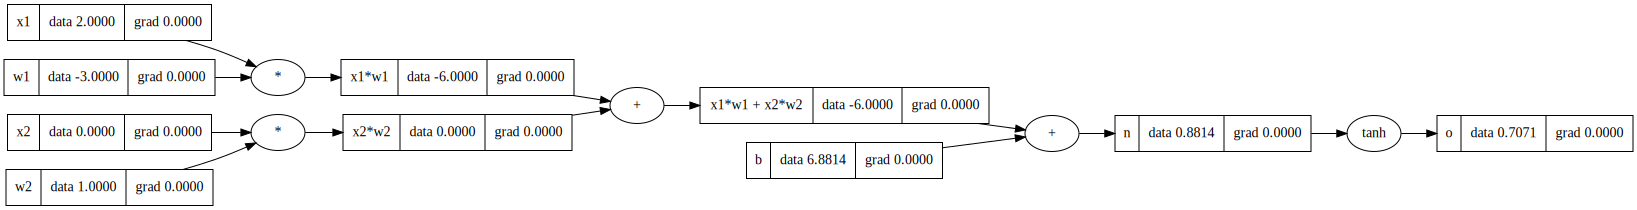

In [169]:
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label="x2")

# WEIGHTS
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

# BIAS OF NEURON

b = Value(6.8814, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n= x1w1x2w2 + b; n.label = "n"
o = n.tanh() 
o.label = "o"

draw_dot(o)


In [173]:
o.backward()

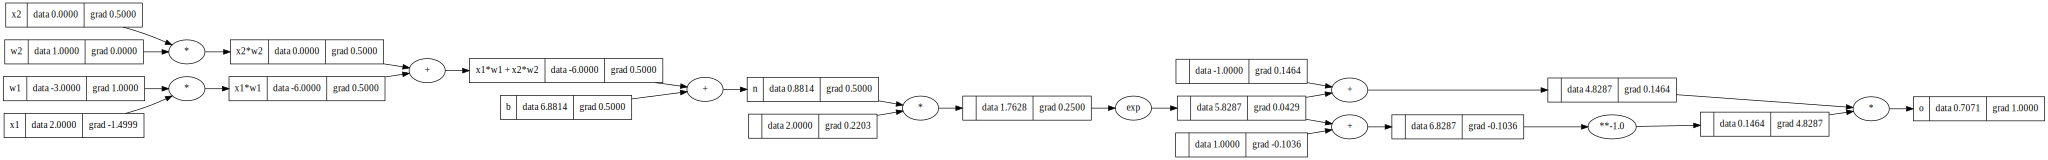

In [174]:

draw_dot(o)

-3.0
1.0
2
0.14644000628493867


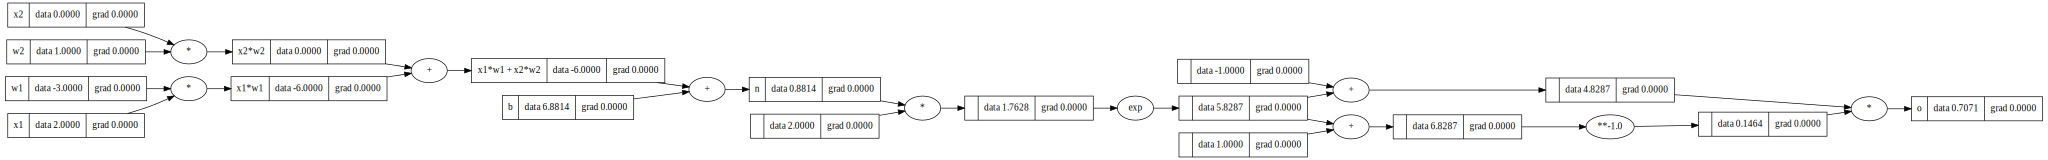

In [172]:
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label="x2")

# WEIGHTS
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

# BIAS OF NEURON

b = Value(6.8814, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n= x1w1x2w2 + b; n.label = "n"
e = (2*n).exp()
o = (e-1) / (e+1) # TANH 

o.label = "o"

draw_dot(o)


In [175]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True # DOUBLE MAKES FLOAT 64 .dtype
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('___')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
___
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [176]:
torch.Tensor([2.0]).double().dtype # LESGO

torch.float64

In [221]:
import random
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x): # instance(x)  # TAKES in X VALUES, and multiplies each Xi with corresponding Wi and appends the b, giving the raw activation
    # w*x + b
    act = sum(wi * xi for wi, xi in zip(self.w, x)) # Creates array of tuples --> ITERATES OVER 2 LISTS
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)] # creates a nuymber of neurons in an array
  
  def __call__(self,x):
    outs = [n(x) for n in self.neurons] # computes each neuron into an array
    return outs[0] if len(outs) == 1 else outs
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x= layer(x)

    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [328]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.6967482748717322)

In [320]:
len(n.parameters())

41

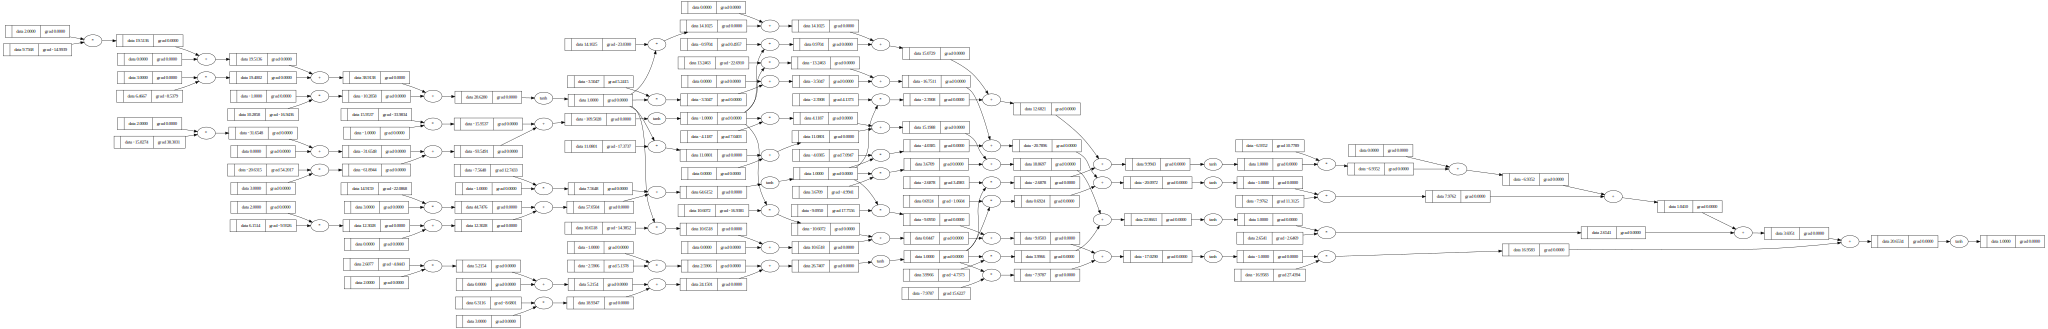

In [319]:
draw_dot(n(x))

In [329]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]

ys = [1.0,-1.0,-1.0,1.0] # DESIRED TARGETS

In [346]:
# LOSS - MSE

#Value(data=7.142510067301163)

for k in range(10):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys,ypred)])

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()# YOU CAN COMPUTE GRADIENT WITH RESPECTIVE TO A LOSS!

  #update 
  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k, loss.data)


0 0.03150981871632087
1 0.031219953461085897
2 0.030934995335043708
3 0.030654825357948688
4 0.030379328271168446
5 0.030108392395961258
6 0.029841909498086117
7 0.029579774658421158
8 0.02932188614928566
9 0.029068145316178455


In [344]:
ypred

[Value(data=0.9262417262550777),
 Value(data=-0.8821685629117558),
 Value(data=-0.911109706260437),
 Value(data=0.9114876876676024)]

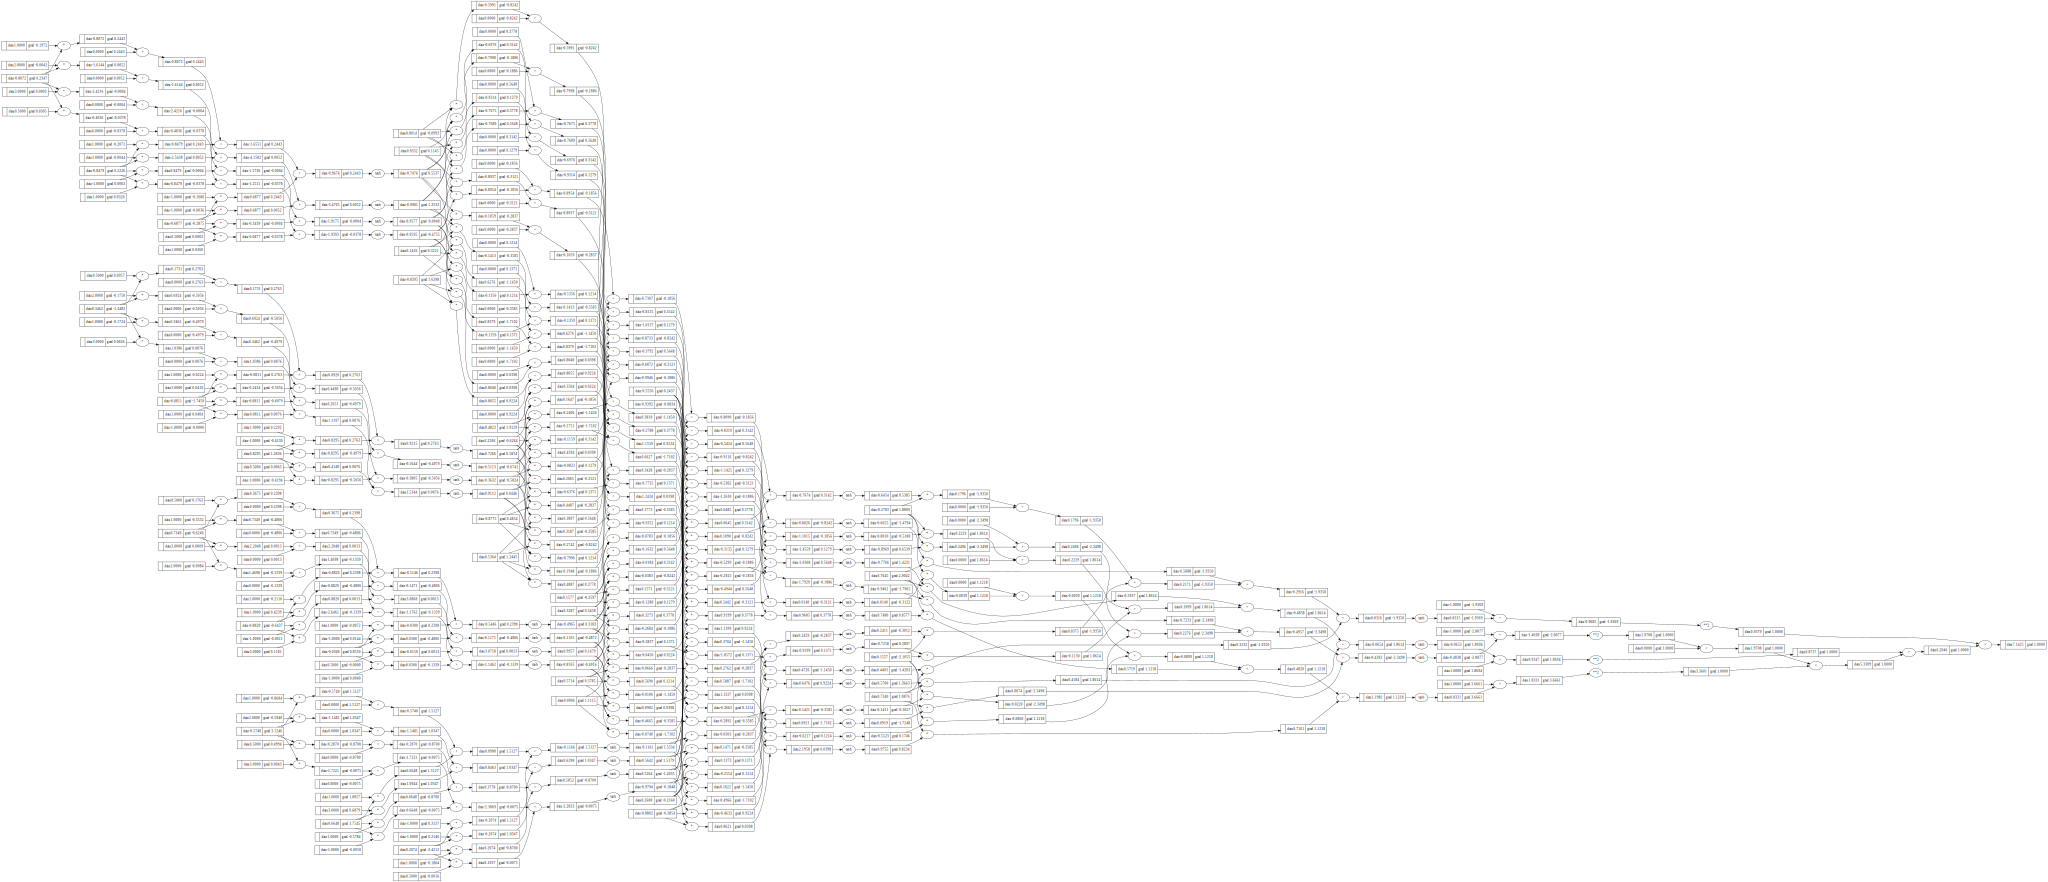

In [231]:
draw_dot(loss)